In [1]:
# install the necessary extra libraries to run the script
#!apt-get update
#!apt-get install chromium chromium-driver
!pip install selenium
!pip install webdriver-manager
!pip install pandas

In [2]:
# import selenium, BeautifulSoup and other libraries to run the script
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from pandas import DataFrame
from bs4 import BeautifulSoup
from IPython.display import Image, display, clear_output
import re
import time
import pandas as pd
import os, shutil

#load location file
location_file=pd.read_csv('Locations.CSV', sep=';')
num_of_locations=len(location_file)

# define constants to define the maximum waiting time and maximum amount of reviews to collect
MAX_WAIT = 10
MAX_PAGES = 20

In [3]:
# define a function to take a screenshot of the headless browser and display it
def take_screenshot(driver):
    driver.save_screenshot("scraping_folder/pageImage.png")
    display(Image(filename="scraping_folder/pageImage.png"))
    print()

In [4]:
# define a function to take a screenshot of the headless browser and display it, then clean the outcome after a few seconds
def take_screenshot_and_clear(driver):
    driver.save_screenshot("scraping_folder/pageImage.png")
    display(Image(filename="scraping_folder/pageImage.png"))
    
    time.sleep(3)
    clear_output(wait=True)

In [5]:
def get_urls(urls, results_list):
    # for each place found
    for elem in results_list:
        # get the element containing its informations
        features = elem['onclick'].split(',')
          
        # extract their url and append them in the list
        url = webpage + features[3].lstrip()[1:-1]
        urls.append(url)
    return urls

In [6]:
def get_reviews(urls, n_ratings):
    driver_new_page = webdriver.Chrome(options=options)
    #for each url in the list
    for url in urls:   
        # get the page with Selenium
        driver_new_page.get(url)
        response = BeautifulSoup(driver_new_page.page_source, 'html.parser')
        
        take_screenshot(driver_new_page)
        # get the number of reviews
        num_reviews = response.find('span', class_="AfQtZ").text
        # cast the number of reviews to the correct type and append in the list
        num_reviews = int(num_reviews.split(' ')[0].replace('.', ''))
        
        n_ratings.append(num_reviews)

        time.sleep(2)
        clear_output(wait=True)
    # close the driver
    driver_new_page.close()
    driver_new_page.quit()

    return n_ratings

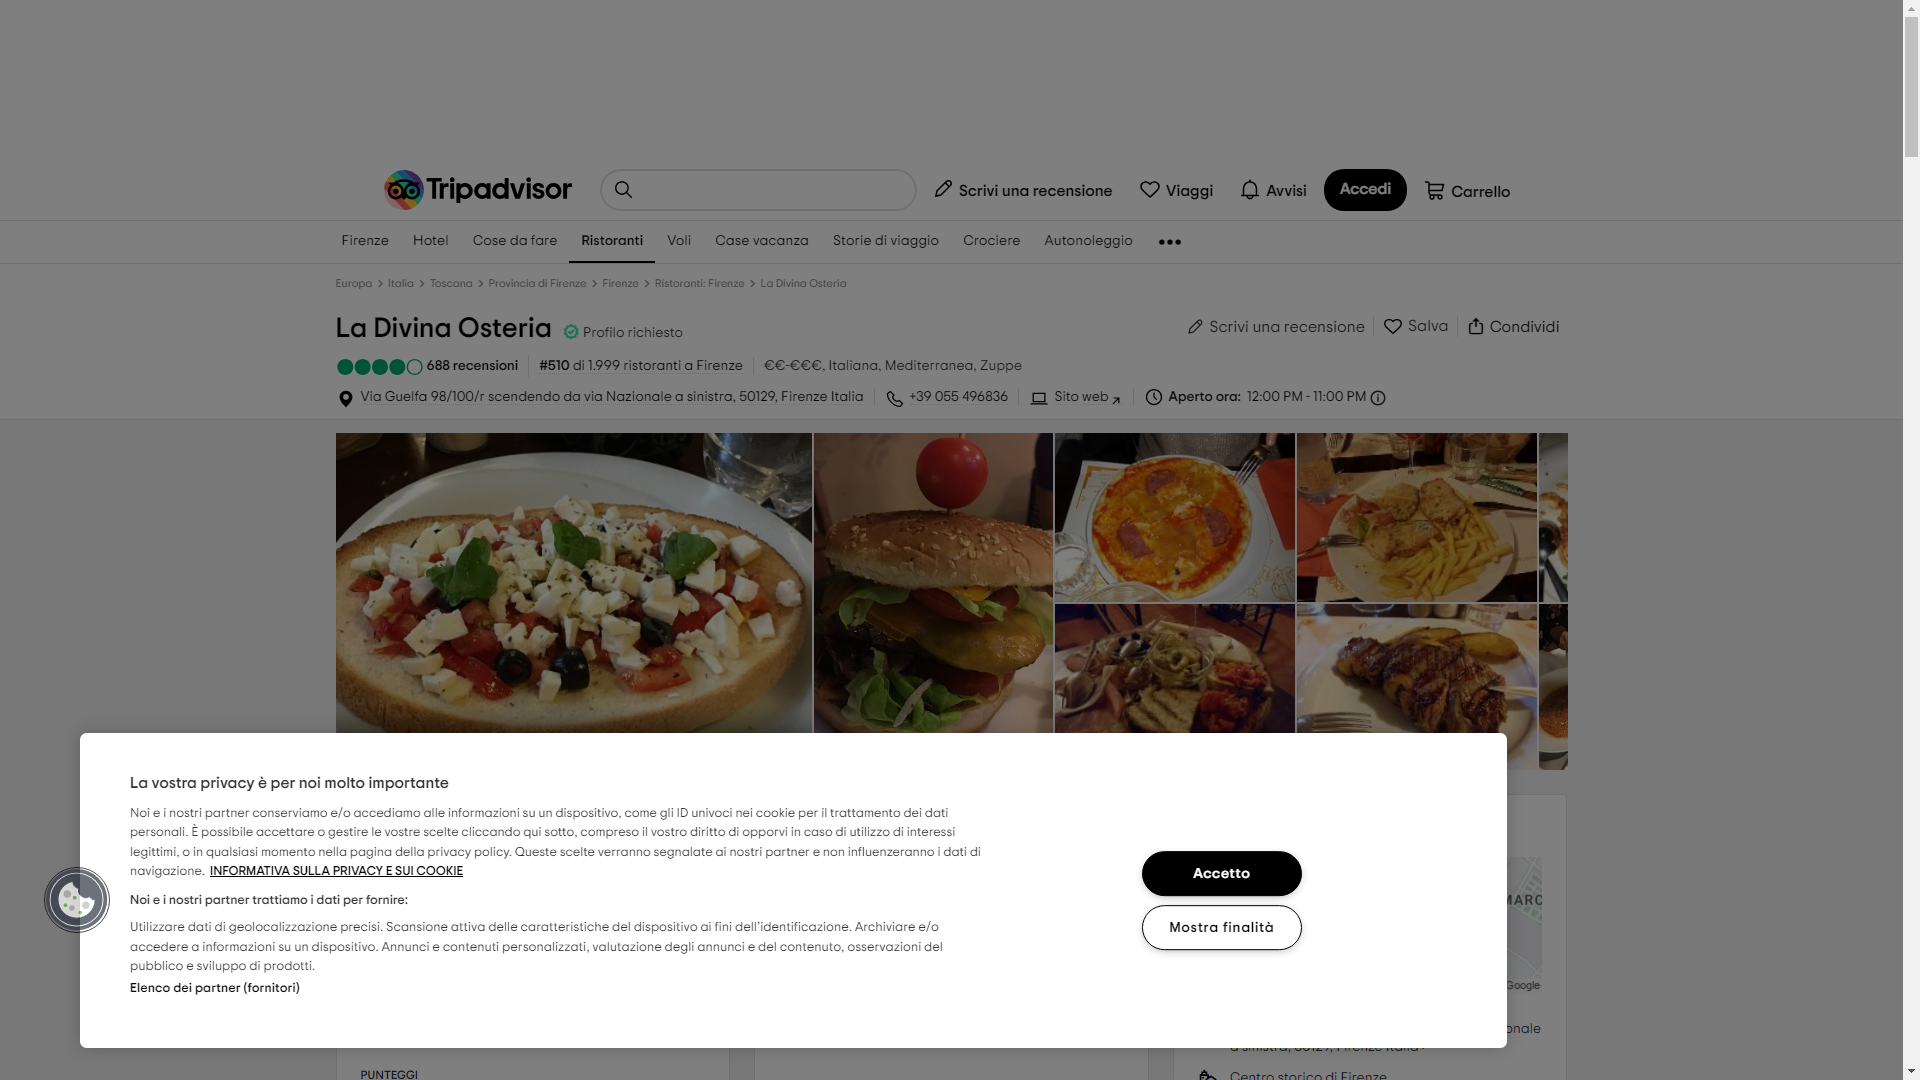

In [14]:
# kill the chrome process to ensure a fresh start
!pkill chrome

# define the options to run Chrome
# IMPORTANT: these options are quite essential, especially when running it in a remote environment like Google Colab
options = webdriver.ChromeOptions()
# define the size of the window
options.add_argument("--window-size=1920,1080")
# disable notifications to avoid useless interactions 
options.add_argument("--disable-notifications")
# disable the developer options
options.add_argument('--disable-dev-shm-usage')
# set the browser to be headless (i.e., the browser window will be hidden)
options.add_argument('--headless')
# set the browser to run all scripts
options.add_argument('--no-sandbox')

#iterate over locations
for index in range(0, num_of_locations):
    #if the location has not urls associated
    if(location_file['#urls'][index]==0):
        # initialize Selenium (Chrome) driver using the set options
        driver = webdriver.Chrome(options=options)
        #retrieve location name
        query=location_file['Location'][index]
        #create a folder with the location name
        os.makedirs(query, exist_ok=True)

        # get tripadvisor's main page
        webpage = 'https://www.tripadvisor.it'
        driver.get(webpage)

        # define an element to wait until an event occurs
        wait = WebDriverWait(driver, MAX_WAIT)

        # wait until the search bar is located on the screen
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'icwvJ'))).find_element(By.CLASS_NAME, 'qjfqs').click()

        take_screenshot_and_clear(driver)

        # wait until the privacy banner is clickable and click it, if it exists
        try:
            if driver.find_element(By.ID,'onetrust-accept-btn-handler') is not None:
                wait.until(EC.element_to_be_clickable((By.ID,'onetrust-accept-btn-handler'))).click()
        except Exception as e:
            print()

        # find the search bar on the screen
        search_bar = driver.find_element(By.CLASS_NAME, 'icwvJ').find_element(By.CLASS_NAME, 'qjfqs')

        # add the query string content to the search bar and then press enter
        search_bar.send_keys(query)
        search_bar.send_keys(Keys.RETURN)

        # wait for the banner with the results to be loaded
        wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'div.search-results-list'))
        )

        take_screenshot_and_clear(driver)

        # specify the category of elements to found (restaurants)
        subfilter = 'Ristoranti'

        # wait for the element with the specified text to be clickable and click it
        field_bt = wait.until(EC.element_to_be_clickable((By.LINK_TEXT, subfilter))).click()

        urls=[]
        n_ratings=[]
        num_pages=0
        
        #to obtain more urls, several pages must be inspected
        while num_pages<MAX_PAGES:
            # wait for search results to load
            wait.until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, 'div.search-results-list'))
                )

            take_screenshot_and_clear(driver)

            # send the page manipulated with Selenium to BeautifulSoup parser
            response = BeautifulSoup(driver.page_source, 'html.parser')

            # get the results and store url
            results_list = response.find_all('div', class_='result-title')

            urls=get_urls(urls, results_list)
            num_pages+=1

            #go to the next page
            driver.find_element("xpath", '//*[@id="BODY_BLOCK_JQUERY_REFLOW"]/div[2]/div/div[2]/div/div/div/div/div[1]/div/div[1]/div/div[3]/div/div[2]/div/div/div/a[2]').click()

        # close the driver
        driver.close()
        driver.quit()

        #collect number of ratings
        n_ratings= get_reviews(urls, n_ratings)

        #save urls and number of ratings in an excel file
        df = DataFrame({'Urls': urls, 'Number of Ratings': n_ratings})
        out_path = query+"\\"+query+".xlsx"
        writer = pd.ExcelWriter(out_path , engine='xlsxwriter')
        df.to_excel(writer, sheet_name='sheet1')
        writer.save()
        
        # update the value of considered urls in the location file
        location_file.loc[index, '#urls'] = len(urls)
        # update the total number of reviews in the location file
        location_file.loc[index, '#reviews'] = sum(n_ratings)

        # writing into the file
        location_file.to_csv("Locations.CSV", index=False)
        